# Synthetic Data (Poisson-Log-Normal)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy 
import matplotlib.pyplot as plt
import seaborn

import time
import pyro
import pyro.poutine as poutine
import pyro.distributions as dist

from pyro.infer.autoguide import AutoDelta, AutoDiagonalNormal, AutoGuideList
from torch.distributions import constraints
from pyro.infer import Predictive

### Helper functions

In [3]:
def plot_few_gene_hist(cell_types_n, counts_ng, other_counts_ng=None, ncols=4):
    assert len(cell_types_n.shape) == 1 
    assert len(counts_ng.shape) == 2
    assert other_counts_ng is None or counts_ng.shape == other_counts_ng.shape
    assert counts_ng.shape[0] == cell_types_n.shape[0]
    
    def _to_torch(_x):
        if isinstance(_x, torch.Tensor):
            return _x
        elif isinstance(_x, numpy.ndarray):
            return torch.tensor(_x)
        else:
            raise Exception("Expected torch.tensor or numpy.ndarray. Received {0}".format(type(_x)))
    
    counts_ng = _to_torch(counts_ng)
    other_counts_ng = None if other_counts_ng is None else _to_torch(other_counts_ng)
    
    ctypes = torch.unique(cell_types_n)
    genes = counts_ng.shape[-1]
    
    
    nrows = genes
    ncols = len(ctypes)
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

    for r in range(genes):
        tmp = counts_ng[:,r]
        other_tmp = None if other_counts_ng is None else other_counts_ng[:,r]
        for c, c_type in enumerate(ctypes):
            tmp2 = tmp[cell_types_n == c_type]
            other_tmp2 = None if other_counts_ng is None else other_tmp[cell_types_n == c_type]
            if other_counts_ng is not None:
                barWidth=0.4
                
                y = torch.bincount(tmp2)
                x = torch.arange(y.shape[0]).cpu().numpy()
                other_y = torch.bincount(other_tmp2)
                other_x = torch.arange(other_y.shape[0]).cpu().numpy() + barWidth
                
                _ = axes[r,c].bar(x, y.cpu().numpy(), width = barWidth)
                _ = axes[r,c].bar(other_x, other_y.cpu().numpy(), width = barWidth)
            else:
                y = torch.bincount(tmp2)
                x = numpy.arange(y.shape[0])
                barWidth=0.9
                _ = axes[r,c].bar(x, y, width = barWidth)
    plt.close()
    return fig


def EMD_between_distributions(distA, distB, normalize: bool=False):
    """
    Eearth mover's distance (aka  Wasserstein distance) has a close form solution in 1D.
    See https://en.wikipedia.org/wiki/Wasserstein_metric)
    """

    sizeA = distA.shape[-1]
    sizeB = distB.shape[-1]
    max_size = max(sizeA, sizeB)
    min_size = min(sizeA, sizeB)
    delta_size = max_size - min_size
    
    padder = torch.nn.ConstantPad1d(padding=(0, delta_size), value=0)
    _distA = padder(distA)[...,:max_size]
    _distB = padder(distB)[...,:max_size]
    
    if normalize:
        normA = _distA.sum(dim=-1, keepdim=True)
        normB = _distB.sum(dim=-1, keepdim=True)
        _distA /= normA
        _distB /= normB
    
    # Actual caltulation 
    _distA_cum = torch.cumsum(_distA, axis=-1)
    _distB_cum = torch.cumsum(_distB, axis=-1)    
    EMD = (_distA_cum - _distB_cum).abs().sum(axis=-1)
    return EMD


def L1_between_distributions(distA, distB, normalize: bool=False):
    """ Simple L1 distance between two distributions. """
    sizeA = distA.shape[-1]
    sizeB = distB.shape[-1]
    max_size = max(sizeA, sizeB)
    min_size = min(sizeA, sizeB)
    delta_size = max_size - min_size
    
    padder = torch.nn.ConstantPad1d(padding=(0, delta_size), value=0)
    _distA = padder(distA)[...,:max_size]
    _distB = padder(distB)[...,:max_size]
    
    if normalize:
        normA = _distA.sum(dim=-1, keepdim=True)
        normB = _distB.sum(dim=-1, keepdim=True)
        _distA /= normA
        _distB /= normB
    
    # Actual calculation
    L1_norm = (_distA - _distB).abs().sum(axis=-1)
    return L1_norm


def compute_median_logprob_per_gene_and_cell_type(cell_types_n, log_prob_ng):
    assert len(log_prob_ng.shape) >= 2
    
    unique_cell_types = torch.unique(cell_types_n)
    k = len(unique_cell_types)
    g = log_prob_ng.shape[-1]
    
    median_kg = torch.zeros((k,g))
    for ik, ctype in enumerate(unique_cell_types):
        log_prob_kg = log_prob_ng[..., cell_types_n == ctype, :].flatten(end_dim=-2)
        assert len(log_prob_kg.shape) == 2
        median_kg[ik] = torch.median(log_prob_kg, axis=-2)[0] 
    return median_kg



def compute_per_cell_type_distributions(cell_types_n, counts_ng):
    """
    Computes the per-cell-type distribution of all the genes
    
    Args:
        cell_types_n: 
        counts_ng:
    
    Returns:
        dist_kgi a tensor of shape (cell_types, genes, max_counts) whose entry represent the number of cells 
        of type k with i counts for gene g.  
    """
    counts_ng = counts_ng.int()
    
    unique_cell_types = torch.unique(cell_types_n)
    i_max = torch.max(counts_ng).item() + 1
    k = len(unique_cell_types)
    g = counts_ng.shape[-1]
    
    dist_kgi = torch.zeros((k,g,i_max))

    for ik, ctype in enumerate(unique_cell_types):
        counts_kg = counts_ng[cell_types_n == ctype]
        for ig in range(g):
            dist_kgi[ik,ig, :] = torch.bincount(counts_kg[:,ig], minlength=i_max) 
    return dist_kgi


def plot_log_prob(cell_types_n, log_prob_ng, other_log_prob_ng=None, ncols=4, bins=20):
    assert len(cell_types_n.shape) == 1 
    assert len(log_prob_ng.shape) >= 2
    assert cell_types_n.shape[0] == log_prob_ng.shape[-2]
    assert other_log_prob_ng is None or (log_prob_ng.shape == other_log_prob_ng.shape)
    
    def _to_torch(_x):
        if isinstance(_x, torch.Tensor):
            return _x
        elif isinstance(_x, numpy.ndarray):
            return torch.tensor(_x)
        else:
            raise Exception("Expected torch.tensor or numpy.ndarray. Received {0}".format(type(_x)))
    
    other_log_prob_ng = None if other_log_prob_ng is None else _to_torch(other_log_prob_ng)
    log_prob_ng = _to_torch(log_prob_ng)
    ctypes = torch.unique(cell_types_n)
    genes = log_prob_ng.shape[-1]
    
    nrows = genes
    ncols = len(ctypes)
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

    for r in range(genes):
        tmp = log_prob_ng[...,r]
        other_tmp = None if other_log_prob_ng is None else other_log_prob_ng[..., r]
        for c, c_type in enumerate(ctypes):
            if other_log_prob_ng is None:
                tmp2 = tmp[..., cell_types_n == c_type]
                y, x = numpy.histogram(tmp2, bins=bins, density=True)
                barWidth = 0.9 * (x[1]-x[0]) 
                _ = axes[r,c].bar(x[:-1], y, width = barWidth)
            else:
                tmp2 = tmp[..., cell_types_n == c_type].flatten()
                other_tmp2 = other_tmp[..., cell_types_n == c_type].flatten()
                myrange = (min(min(tmp2), min(other_tmp2)).item(), max(max(tmp2), max(other_tmp2)).item())
                y, x = numpy.histogram(tmp2, range=myrange, bins=bins, density=True)
                other_y, other_x = numpy.histogram(other_tmp2, range=myrange, bins=bins, density=True)
                barWidth = 0.4 * (x[1]-x[0]) 
                _ = axes[r,c].bar(x[:-1], y, width = barWidth)
                _ = axes[r,c].bar(other_x[:-1]+barWidth, other_y, width = barWidth)
       
    plt.close()
    return fig

### Generate fake data and visualize

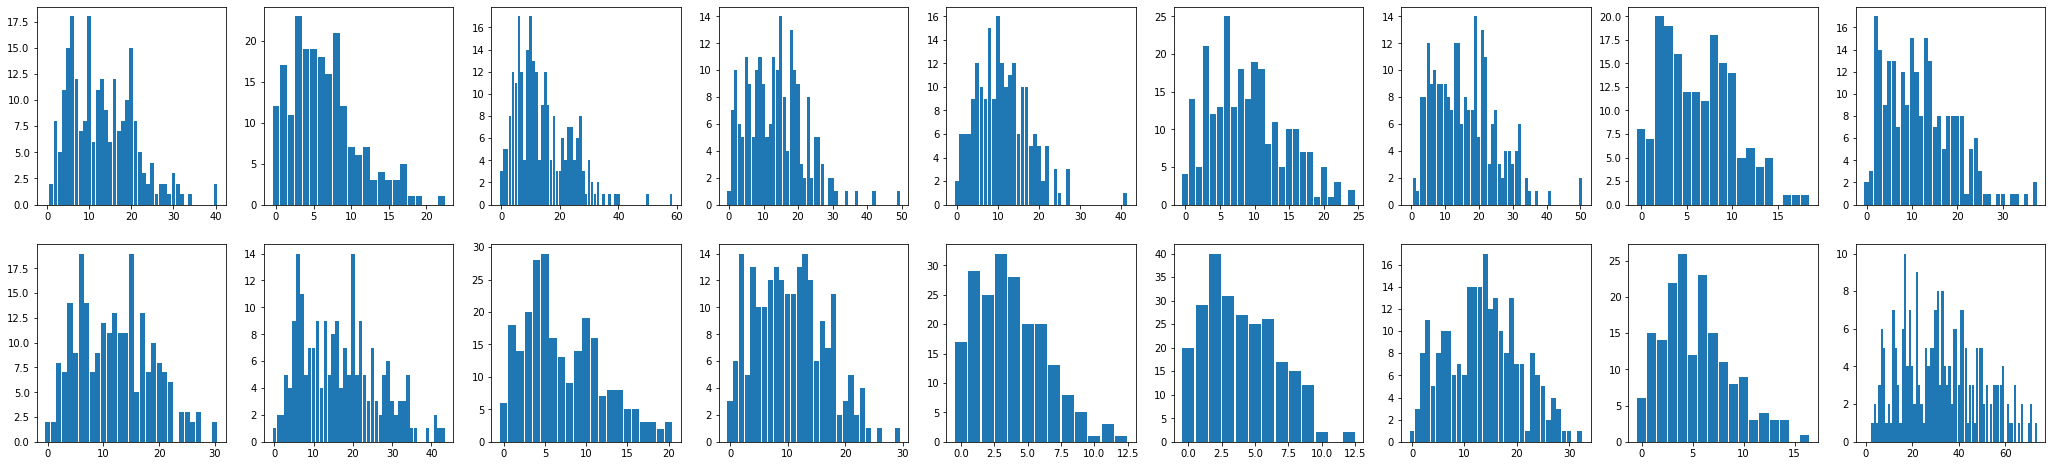

In [4]:
from tissue_purifier.model_utils.gene_regression import (
    generate_fake_data, 
    GeneDataset, 
    GeneRegression,
    train_test_val_split
)

fake_dataset: GeneDataset = generate_fake_data(
    cells=2000,
    genes=50,
    covariates=20,
    cell_types=9,
    alpha_scale=0.01,
    alpha0_loc=-5.0,
    alpha0_scale=0.5,
    noise_scale= 0.1)
    
    
counts_ng = fake_dataset.counts
cell_types_n = fake_dataset.cell_type_ids
fig = plot_few_gene_hist(cell_types_n, counts_ng[:,:2])
fig

# Model

In [5]:
genex = GeneRegression()

  Trace Shapes:                
   Param Sites:                
          eps_g              50
         alpha0       9    1 50
  Sample Sites:                
     cells dist               |
          value         2000  |
       log_prob               |
cell_types dist               |
          value            9  |
       log_prob               |
 covariate dist               |
          value           20  |
       log_prob               |
     genes dist               |
          value           50  |
       log_prob               |
     alpha dist    9 20   50  |
          value    9 20   50  |
       log_prob    9 20   50  |
    counts dist 2000  1   50  |
          value 2000  1   50  |
       log_prob 2000  1   50  |


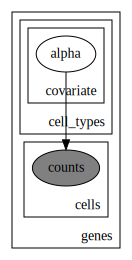

In [6]:
genex.render_model(fake_dataset)

### Train/Test/Val split

In [7]:
sss = train_test_val_split(data=fake_dataset,
                           train_size=0.8,
                           test_size=0.1,
                           val_size=0.1,
                           n_splits=1,
                           stratify=True)

for train_dataset, test_dataset, val_dataset in sss:
    print(train_dataset.counts.shape, test_dataset.counts.shape, val_dataset.counts.shape)

torch.Size([1600, 50]) torch.Size([200, 50]) torch.Size([200, 50])


In [10]:
genex.configure_optimizer(optimizer_type='adam', lr=5E-3)
ckpt_list = [] 

for alpha_scale in [1E-4, 1E-3, 1E-2, 1E-1, 1.0, 10]:
    genex.train(dataset=train_dataset, 
                alpha_scale=alpha_scale, 
                use_covariates=True, 
                eps_g_range=(1.0E-5, 0.5), 
                n_steps=5000, 
                print_frequency=100, 
                from_scratch=True)
    filename = "./train_alpha_{0}.pt".format(alpha_scale)
    ckpt_list.append(filename)
    genex.save_ckpt(filename=filename)

[iter 0]  loss: 14225620.3672
[iter 0]  loss: 14246343.6562
[iter 0]  loss: 14267066.9023
[iter 0]  loss: 14287790.1807
[iter 0]  loss: 14308513.4463
[iter 0]  loss: 14329236.7148


./train_alpha_0.0001.pt 158.56479 543.8746
./train_alpha_0.001.pt 159.6813 547.3445
./train_alpha_0.01.pt 157.5506 542.0393
./train_alpha_0.1.pt 157.30292 542.68353
./train_alpha_1.0.pt 157.30206 542.34546
./train_alpha_10.pt 157.30206 540.922


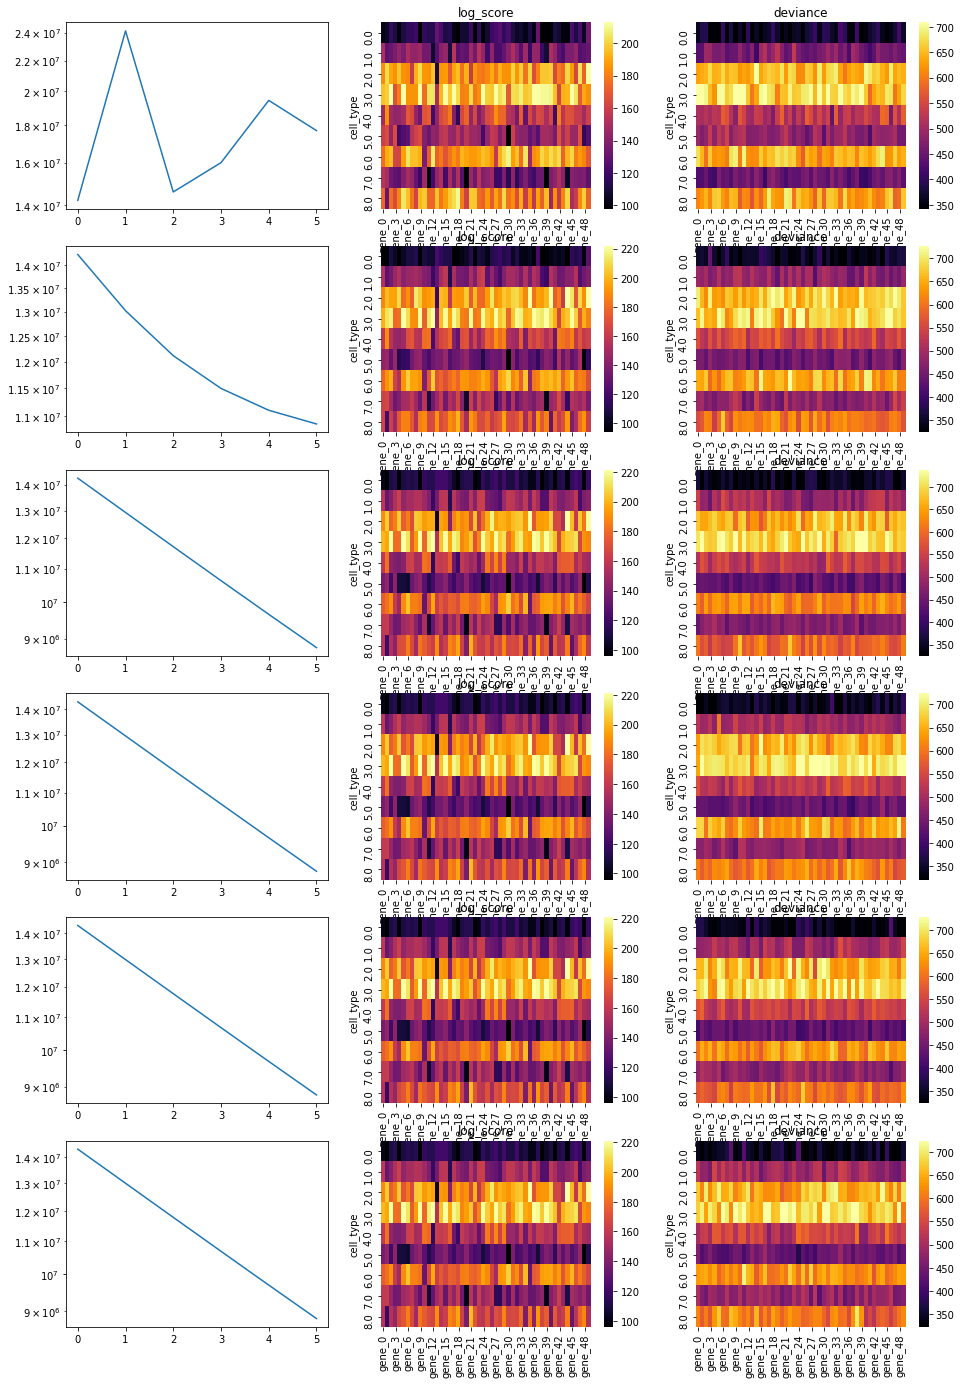

In [19]:
fig, axes = plt.subplots(nrows=len(ckpt_list), ncols=3, figsize=(16,4*len(ckpt_list)))

for r, ckpt in enumerate(ckpt_list):
    genex.load_ckpt(filename=ckpt)
    results, df_logscore, df_deviance = genex.predict(dataset=test_dataset)
    df1 = df_logscore.groupby(by="cell_type").median()
    df2 = df_deviance.groupby(by="cell_type").median()
    
    _ = genex.show_loss(logy=True, logx=False, ax=axes[r,0])
    _ = seaborn.heatmap(data=df1, cmap="inferno", robust=True, ax=axes[r,1])
    _ = axes[r,1].set_title("log_score")
    _ = seaborn.heatmap(data=df2, cmap="inferno", robust=True, ax =axes[r,2])
    _ = axes[r,2].set_title("deviance")
    
    print(ckpt, df1.mean().mean(), df2.mean().mean())

# Then do on validation a more complete analysis

In [ ]:
g = sns.catplot(x="alive", col="cell_type", col_wrap=4,
                data=df_deviance,
                kind="violin")

# from here
train, cross_validation, test on 
read scoring metrics:
need to add evalute method
    
https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.67.3696&rep=rep1&type=pdf

# FROM HERE. DO THE SUMMARY PLOT

In [ ]:
nmax = len(log_prob_list)
ncol = 3
nrow = int(numpy.ceil(float(nmax)/ncol))
fig, axes = plt.subplots(ncols=ncol, nrows=nrow, figsize=(4*ncol, 4*nrow))

for n, log_prob in enumerate(log_prob_list):
    r,c = int(n / ncol), n % ncol
    median_kg = compute_median_logprob_per_gene_and_cell_type(cell_types_n, tmp_log_prob)
    mean_log_prob = median_kg.mean()
    _ = seaborn.heatmap(median_kg, cmap="inferno", robust=True, ax=axes[r,c])
    _ = axes[r,c].set_title("mean_log_prob = {0:.3f}".format(mean_log_prob))

In [ ]:
median_kg = compute_median_logprob_per_gene_and_cell_type(cell_types_n, tmp_log_prob)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
_ = fig.suptitle("Distance between true counts distribution and estimates")

_ = seaborn.heatmap(median_kg, cmap="inferno", robust=True, ax=axes[0,0])
_ = axes[0,0].set_title("log_prob model 1")

# FROM HERE

### Just for visualization: Plot the predicted_counts vs the real_counts

In [ ]:
fig_A = plot_few_gene_hist(cell_types_n, true_counts_ng[:,:2], predA_counts_ng[:,:2].int(), ncols=3)
fig_B = plot_few_gene_hist(cell_types_n, true_counts_ng[:,:2], predB_counts_ng[:,:2].int(), ncols=3)
fig_C = plot_few_gene_hist(cell_types_n, true_counts_ng[:,:2], predC_counts_ng[:,:2].int(), ncols=3)

## Quantify the variance 
1. at the level of distributions
2. at the level of single predictions

### at the level of distributions

In [ ]:
true_dist_kgi = compute_per_cell_type_distributions(cell_types_n, true_counts_ng)
predA_dist_kgi = compute_per_cell_type_distributions(cell_types_n, predA_counts_ng)
predB_dist_kgi = compute_per_cell_type_distributions(cell_types_n, predB_counts_ng)
predC_dist_kgi = compute_per_cell_type_distributions(cell_types_n, predC_counts_ng)

In [ ]:
L1_norm_A = L1_between_distributions(true_dist_kgi, predA_dist_kgi, normalize=True)
L1_norm_B = L1_between_distributions(true_dist_kgi, predB_dist_kgi, normalize=True)
L1_norm_C = L1_between_distributions(true_dist_kgi, predC_dist_kgi, normalize=True)

EMD_norm_A = EMD_between_distributions(true_dist_kgi, predA_dist_kgi, normalize=True)
EMD_norm_B = EMD_between_distributions(true_dist_kgi, predB_dist_kgi, normalize=True)
EMD_norm_C = EMD_between_distributions(true_dist_kgi, predC_dist_kgi, normalize=True)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
_ = fig.suptitle("Distance between true counts distribution and estimates")

_ = seaborn.heatmap(L1_norm_A, cmap="inferno", robust=True, ax=axes[0,0])
_ = seaborn.heatmap(L1_norm_B, cmap="inferno", robust=True, ax=axes[0,1])
_ = seaborn.heatmap(L1_norm_C, cmap="inferno", robust=True, ax=axes[0,2])
_ = axes[0,0].set_title("L1 wrt MLE estimates")
_ = axes[0,1].set_title("L1 wrt MAP estimates")
_ = axes[0,2].set_title("L1 wrt MAP estimates, alpha0 no prior")

_ = seaborn.heatmap(EMD_norm_A, cmap="inferno", robust=True, ax=axes[1,0])
_ = seaborn.heatmap(EMD_norm_B, cmap="inferno", robust=True, ax=axes[1,1])
_ = seaborn.heatmap(EMD_norm_C, cmap="inferno", robust=True, ax=axes[1,2])
_ = axes[1,0].set_title("EMD wrt MLE estimates")
_ = axes[1,1].set_title("EMD wrt MAP estimates")
_ = axes[1,2].set_title("EMD wrt MAP estimates, alpha0 no prior")

In [ ]:
print(L1_norm_A.median(), L1_norm_B.median(), L1_norm_C.median())
print(EMD_norm_A.median(), EMD_norm_B.median(), EMD_norm_C.median())

## At the level of single predictions

In [ ]:
from tissue_purifier.misc_utils.validation import (
    create_null_distribution,
    create_heldout_distribution
)

null_dist = create_null_distribution(
    cell_types_n=cell_types_n, 
    counts_ng=counts_ng[:,:10], 
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)   


heldout_dist = create_heldout_distribution(
    cell_types_n=cell_types_n, 
    true_counts_ng=counts_ng[:,:10], 
    pred_counts_ng=counts_ng[:,:10]+1,
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)   

### test the procedure by creating two fake distributions

In [ ]:
null_dist = create_null_distribution(
    cell_types_n=cell_types_n[-1000:], 
    counts_ng=counts_ng[-1000:,:10], 
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)     

heldout_dist = create_null_distribution(
    cell_types_n=cell_types_n[:1000], 
    counts_ng=counts_ng[:1000,:10], 
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)     

In [ ]:
gene_id = 1

x_null = null_dist["cell_type_0"][gene_id,:] / numpy.sum(null_dist["cell_type_0"][gene_id,:], axis=-1, keepdims=True)
x_heldout = heldout_dist["cell_type_0"][gene_id,:] / numpy.sum(heldout_dist["cell_type_0"][gene_id,:], axis=-1, keepdims=True)

barWidth=0.4
plt.bar(null_dist["boundaries"], 
        x_null, 
        width = barWidth,
       label="null")
plt.bar(heldout_dist["boundaries"]+barWidth, 
        x_heldout,
        width = barWidth,
       label="Heldout")
_ = plt.xlim([-1,20])
_ = plt.legend()
_ = plt.title("Distribution of Chi = |counts - counts|")

In [ ]:
gene_id = 6

x_null = null_dist["cell_type_0"][gene_id,:] / numpy.sum(null_dist["cell_type_0"][gene_id,:], axis=-1, keepdims=True)
x_heldout = heldout_dist["cell_type_0"][gene_id,:] / numpy.sum(heldout_dist["cell_type_0"][gene_id,:], axis=-1, keepdims=True)

barWidth=0.4
plt.bar(null_dist["boundaries"], 
        x_null, 
        width = barWidth,
       label="null")
plt.bar(heldout_dist["boundaries"]+barWidth, 
        x_heldout,
        width = barWidth,
       label="Heldout")
_ = plt.xlim([-1,20])
_ = plt.legend()
_ = plt.title("Distribution of Chi = |counts - counts|")

### Two-sample Kolmogorov–Smirnov test
I am asking the question if the two distribution are the same


In [ ]:
from scipy.interpolate import interp1d
from typing import NamedTuple, Union
    
class KS_test(NamedTuple):
    """ 
    Result of the KS test between two empirical distributions.
    """
    x: numpy.ndarray
    f1: numpy.ndarray
    f2: numpy.ndarray
    gap: numpy.ndarray
    ks: Union[float, numpy.ndarray]
    n1: Union[int, numpy.array]
    n2: Union[int, numpy.array]
        

def compute_pvalue_from_ks(ks_test: KS_test) -> numpy.ndarray:
    """
    Compute the p-value using the asymptotic formula 
    see. https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
    """
    n1 = ks_test.n1
    n2 = ks_test.n2
    D = ks_test.ks
    tmp = (2 * D * D * n1 * n2) / (n1 + n2)
    p = 2 * numpy.exp(-tmp)
    return p

    
def compute_KS_test(x1, histo1, x2, histo2) -> KS_test:
    
    # (empirical) cumulative distribution and size of sample
    F1_tmp = histo1.cumsum(axis=-1) # shape (genes, bins)
    n1 = F1_tmp[...,-1:]            # shape (genes, 1)
    F1 = F1_tmp / n1                # shape (genes, bins)
    
    # (empirical) cumulative distribution and size of sample
    F2_tmp = histo2.cumsum(axis=-1) 
    n2 = F2_tmp[..., -1:]
    F2 = F2_tmp / n2
    
    # Interpolate sample 1 on the spacing of sample 2 
    f_interp = interp1d(x1, F1, axis=-1, fill_value=(0.0, 1.0))
    F1_new = f_interp(x2)
    
    # Comute the maximum gap between empirical cumulative distributions
    gap = numpy.abs(F1_new - F2)
    ks = numpy.max(gap, axis=-1, keepdims=True)
    
    return KS_test(x=x2, f1=F1_new, f2=F2, n1=n1, n2=n2, gap=gap, ks=ks)


key_cell_types = []
for key in null_dist.keys():
    if key.startswith("cell_type_"):
        key_cell_types.append(key)
    

#df = pandas.DataFrame()
for k in key_cell_types:        
    
    ks_test_tmp = compute_KS_test(
        x1=null_dist["boundaries"], 
        histo1=null_dist["cell_type_0"], 
        x2=heldout_dist["boundaries"], 
        histo2=heldout_dist["cell_type_0"])
    
    p_values_tmp = compute_pvalue_from_ks(ks_test_tmp)
    
    
    
#    dfdf = pd.DataFrame(columns=["firstname", "lastname"])
#df = df.append({
#     "firstname": "John",
#     "lastname":  "Johny"
#      }, ignore_index=True)
    
    dict_tmp = {'ks' : ks_test_tmp.ks, 'p_value': p_values_tmp, 'cell_type': [k]*len(p_values_tmp)}

In [ ]:
ncol = 4
nmax = len(ks_test.ks)
nrow = int(numpy.ceil(float(nmax) / ncol))

fig, axes = plt.subplots(ncols=ncol, nrows=nrow, figsize=(4*ncol, 4*nrow))
for n in range(nmax):
    r,c = n // ncol, n % ncol
    axes[r,c].plot(ks_test.x, ks_test.f1[n,:])
    axes[r,c].plot(ks_test.x, ks_test.f2[n,:])
    axes[r,c].plot(ks_test.x, ks_test.gap[n,:])
    axes[r,c].set_xlim([0,20])
    axes[r,c].set_title("ks={0:.3} -> pvalue={1:.3}".format(ks_test.ks[n].item(), p_values[n].item()))